In [1]:
import matplotlib.patches as patches
import torchvision.transforms as transforms
import numpy as np
import torch 
from model import Yolov1
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
    save_model,
    load_model #my loader below
)
from loss import YoloLoss
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms as T
from PIL import Image


In [2]:
DEVICE = torch.device('mps')# to use the M1 MAC GPU
LEARNING_RATE = 2e-5

LOAD_MODEL_FILE = "./saved_models/overfitted-YoloV1-train-on-100img-and-4096.pt" 
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0)
# loss_fn = YoloLoss()
load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
model.eval()

=> Loading checkpoint


Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBloc

In [3]:

class Compose(object):
    """Resize and transform to tensor"""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes): # bboxes = bounding boxes
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

# one thing that can improve this is that u do a normalization. mean = 0 and standard deviation = 1
transforms = Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor() # convert to tensors and NOTE: normalizes it under the hood
])


In [4]:
img = cv2.imread('./data/images/000010.jpg')  # Replace with your image path
img, img.shape

(array([[[226, 202, 166],
         [226, 202, 166],
         [226, 202, 166],
         ...,
         [126, 133, 142],
         [124, 130, 141],
         [128, 137, 147]],
 
        [[227, 203, 167],
         [227, 203, 167],
         [227, 203, 167],
         ...,
         [144, 151, 160],
         [135, 144, 154],
         [131, 140, 150]],
 
        [[226, 201, 167],
         [226, 201, 167],
         [226, 201, 167],
         ...,
         [130, 137, 146],
         [126, 135, 145],
         [115, 124, 134]],
 
        ...,
 
        [[ 56, 127, 111],
         [ 52, 123, 107],
         [ 94, 164, 151],
         ...,
         [ 76, 148, 136],
         [ 85, 157, 145],
         [ 97, 169, 156]],
 
        [[ 59, 129, 112],
         [ 49, 119, 102],
         [ 92, 161, 146],
         ...,
         [ 89, 161, 148],
         [ 86, 158, 145],
         [ 84, 159, 143]],
 
        [[ 88, 158, 141],
         [105, 175, 158],
         [ 96, 163, 148],
         ...,
         [ 79, 151, 138],
  

In [ ]:
# img = cv2.resize(img, (448,448))
# img.shape

(448, 448, 3)

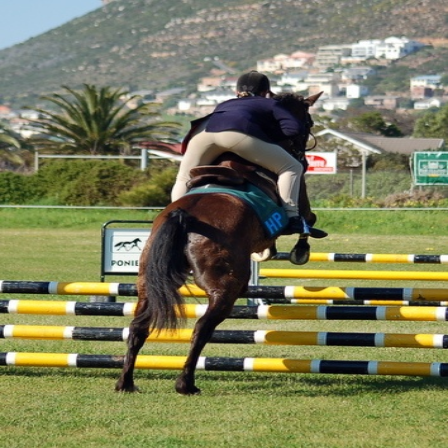

In [6]:
image_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
image_pil

In [7]:
model_input, bboxes = transforms(image_pil, [])
model_input, model_input.shape

(tensor([[[0.6510, 0.6510, 0.6510,  ..., 0.5569, 0.5608, 0.5765],
          [0.6549, 0.6549, 0.6549,  ..., 0.6118, 0.5922, 0.5804],
          [0.6549, 0.6549, 0.6549,  ..., 0.5647, 0.5529, 0.5255],
          ...,
          [0.4431, 0.4353, 0.5059,  ..., 0.5529, 0.5843, 0.6118],
          [0.4392, 0.4118, 0.4824,  ..., 0.5725, 0.5686, 0.5647],
          [0.5490, 0.5922, 0.5961,  ..., 0.5412, 0.5255, 0.4902]],
 
         [[0.7922, 0.7922, 0.7922,  ..., 0.5176, 0.5176, 0.5373],
          [0.7961, 0.7961, 0.7961,  ..., 0.5725, 0.5529, 0.5412],
          [0.7882, 0.7882, 0.7882,  ..., 0.5255, 0.5137, 0.4863],
          ...,
          [0.5020, 0.4941, 0.5608,  ..., 0.5961, 0.6314, 0.6588],
          [0.5059, 0.4784, 0.5451,  ..., 0.6235, 0.6196, 0.6275],
          [0.6157, 0.6588, 0.6588,  ..., 0.6000, 0.5882, 0.5529]],
 
         [[0.8863, 0.8863, 0.8863,  ..., 0.4902, 0.4941, 0.5020],
          [0.8902, 0.8902, 0.8902,  ..., 0.5412, 0.5176, 0.5059],
          [0.8863, 0.8863, 0.8863,  ...,

In [8]:
model_input = model_input.unsqueeze(0).to(DEVICE)
model_input.shape

torch.Size([1, 3, 448, 448])

In [9]:
# # run interference
with torch.no_grad():
    output = model(model_input) 

In [10]:
bboxes = cellboxes_to_boxes(output)
# the bboxes[0] below is becuase we are only working with one image at a time, if u have a batch loop thru it and pass its idx instead
bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

In [11]:
model_input.squeeze(0).permute(1, 2, 0).shape

torch.Size([448, 448, 3])

In [14]:
type(model_input.squeeze(0).permute(1, 2, 0)), model_input.squeeze(0).permute(1, 2, 0).shape

(torch.Tensor, torch.Size([448, 448, 3]))



Object : id:14.0, ('person', {0.426517128944397})


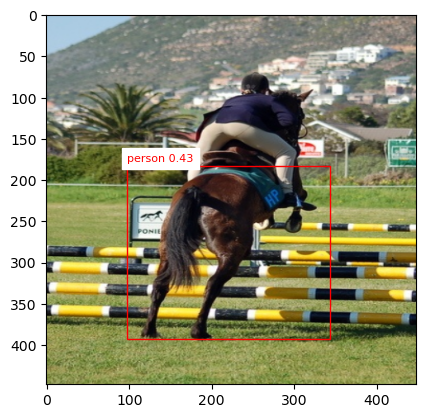

In [16]:
plot_image(model_input.squeeze(0).permute(1, 2, 0), bboxes)